Date : 03/27/2022<br />
Author : Xueying Li<br />
Description : This file is used to test and evaluate the model's accuracy<br />
Reference: I used part of code from https://github.com/mazabdul7/AtTheEdge/blob/main/Training.ipynb.<br /> 

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pathlib
from tensorflow.keras import layers
import random

from sklearn.metrics import confusion_matrix

In [21]:
print(tf.__version__) # TF Version

2.9.0-dev20220203


Build the model

In [22]:
# Set variables for testing
# checkpoint weight to test
modelCheckPointName='bestmodel95_79_224.hdf5'
modelStructure = "mobilenet" # or "efficientnet"
batch_size = 16
basemodel_img_height = 224
basemodel_img_width = 224

In [23]:
def createModel(modelStructure,modelCheckPointName,basemodel_img_height,basemodel_img_width,batch_size):
    # Don't use augumentation layer in tensorflow 2.9, it may show error (it will work in other versions of tensorflow)
    #Load EfficientNet base or MobileNet with weights pre-trained on ImageNet
    if modelStructure =="mobilenet":
        base_model =tf.keras.applications.MobileNetV3Large(input_shape=(basemodel_img_height, basemodel_img_width, 3),include_top=False,weights='imagenet')
    elif modelStructure=="mobilenets":
        base_model =tf.keras.applications.MobileNetV3Small(input_shape=(basemodel_img_height, basemodel_img_width, 3),include_top=False,weights='imagenet')
    elif modelStructure =="efficientnet":
        base_model = tf.keras.applications.EfficientNetB0(
        weights="imagenet",
        input_shape=(basemodel_img_height, basemodel_img_width, 3),
        include_top=False)
    # Unfreeze base model
    base_model.trainable = True

    # Create new model on top
    inputs = tf.keras.Input(shape=( 384, 512, 3))
    # Apply random data augmentation
    # Resize layer to basemodel inputsize (only used in downscal=ling)
    if (basemodel_img_width,basemodel_img_height) != (384,512):
        x=tf.keras.layers.Resizing(basemodel_img_width,basemodel_img_height)(inputs)
        x = base_model(x, training=False)
    else:
        x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    #There are seven class
    outputs = tf.keras.layers.Dense(7, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    model.load_weights(modelCheckPointName)
    model.summary()
    return model

Test the model

In [24]:
# Create the confusion matrix plot
def cmplot(correctLabel,predictedLabel,labels,titleName):
    confusionmatrix = confusion_matrix(correctLabel,predictedLabel)
    cm= []
    cm = confusionmatrix/confusionmatrix.sum(axis=0)
    print(cm)
    cm=np.mean(cm.diagonal())
    print(cm)
    # Make the confusion matrix plot
    fig, axes = plt.subplots()
    axes.imshow(confusionmatrix, cmap = plt.cm.GnBu,interpolation='nearest')
    axes.set_title(titleName)
    n = np.array(range(len(labels)))
    axes.set_yticks(n)
    axes.set_yticklabels(labels)
    axes.set_xticks(n)
    axes.set_xticklabels(labels, rotation=45)
    threshold = confusionmatrix.max() / 2. 
    for i in range(len(confusionmatrix)):
        for j in range(len(confusionmatrix[0])):
            axes.text(j, i, format(confusionmatrix[i, j], 'd'),horizontalalignment = 'center', 
                                   color = 'white' if confusionmatrix[i, j] > threshold else "black")
        axes.set_ylabel('True label')
        axes.set_xlabel('Predicted label')

In [25]:
#Import test set as images
def testAccuracy(testDataName,titleName,label):
    model=createModel(modelStructure,modelCheckPointName,basemodel_img_height,basemodel_img_width,batch_size)
    labels = ["cardboard", "empty","glass","hand","metal", "paper", "plastic"]
    wrongCount = 0
    predictedLabel = []
    correctLabel=[]
    wrongImage = []
    img = keras.preprocessing.image.DirectoryIterator(
        testDataName, tf.keras.preprocessing.image.ImageDataGenerator(), target_size=(384, 512), batch_size=1,shuffle=False)
    for index in range(len(img)):
        predictions = model.predict(img[index][0])
        predictedLabel.append(np.argmax(predictions))
        for j in img[index][1]: 
            if np.argmax(predictions) != j.tolist().index(1):
                wrongCount+=1
                wrongImage.append(img[index])
                plt.figure(figsize=(5,5))
                plt.imshow(((1-img[index][0][0])*255).astype('uint8'))
                plt.show()
        correctLabel.append(j.tolist().index(1))
    print("The test accuracy is " + str(((len(img)-wrongCount)/len(img))*100) + "%")
    cm = confusion_matrix(correctLabel,predictedLabel)
    cm =cm/cm.sum(axis=1)
    cm=np.mean(cm.diagonal())
    print("The perclass accuracy is " + str(cm) + "%")
    cmplot(correctLabel,predictedLabel,label,titleName)
    return [wrongImage,model]

In [10]:
def displayWrongImage(wrongImage):
    for i in wrongImage:
        plt.figure(figsize=(5,5))
        plt.imshow(((1-i[0][0])*255).astype('uint8'))
        plt.show()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 512, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 7)                 6727      
                                                                 
Total params: 3,003,079
Trainable params: 2,978,679
Non-train

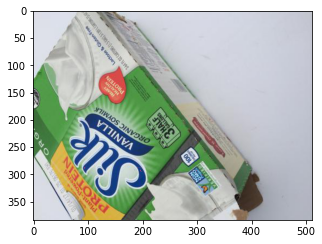

1/1 [==============================] - 0s 27ms/step


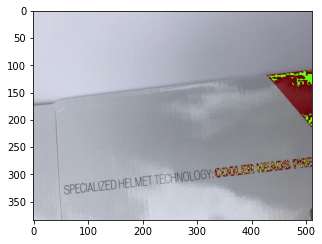

1/1 [==============================] - 0s 28ms/step


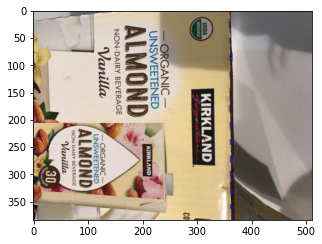

1/1 [==============================] - 0s 27ms/step


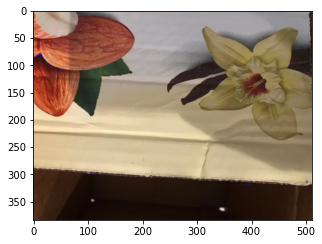

1/1 [==============================] - 0s 28ms/step


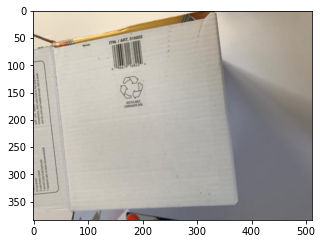

1/1 [==============================] - 0s 29ms/step


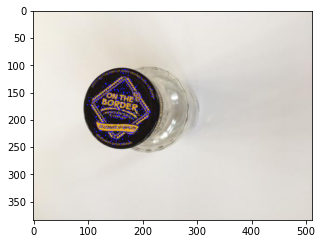

1/1 [==============================] - 0s 31ms/step


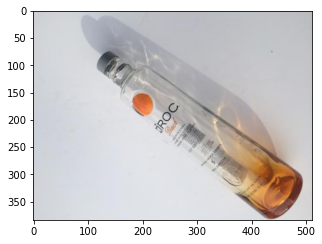

1/1 [==============================] - 0s 29ms/step


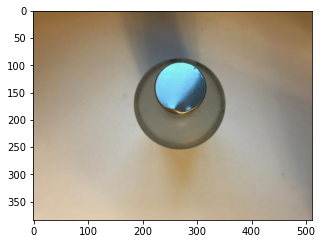

1/1 [==============================] - 0s 29ms/step


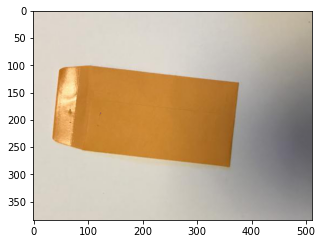

1/1 [==============================] - 0s 30ms/step


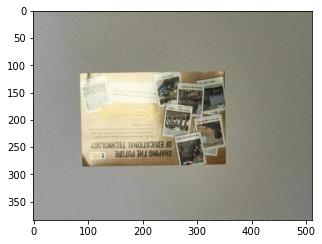

1/1 [==============================] - 0s 31ms/step


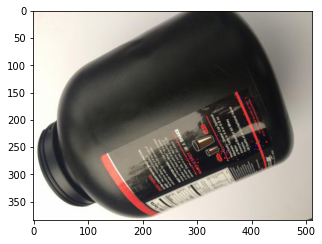

1/1 [==============================] - 0s 29ms/step


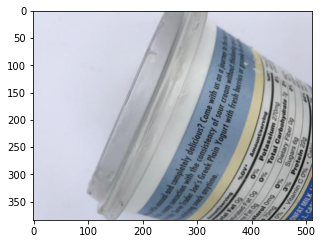

1/1 [==============================] - 0s 30ms/step


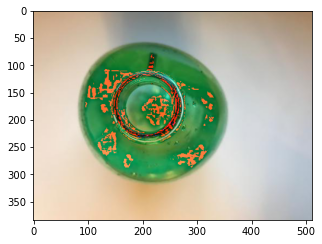

1/1 [==============================] - 0s 29ms/step


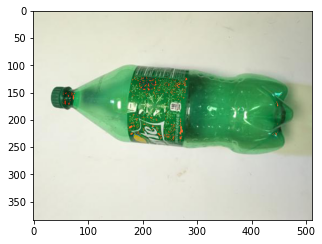

1/1 [==============================] - 0s 29ms/step


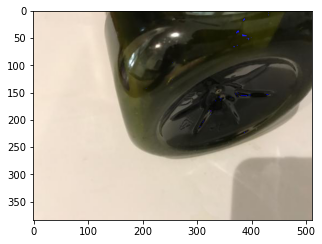

1/1 [==============================] - 0s 29ms/step
The test accuracy is 95.7983193277311%
The perclass accuracy is 0.9569500624219724%
[[0.91666667 0.         0.         0.05617978 0.        ]
 [0.         0.96       0.01639344 0.         0.02777778]
 [0.         0.         1.         0.         0.        ]
 [0.03333333 0.         0.         0.97752809 0.        ]
 [0.         0.05333333 0.01639344 0.         0.93055556]]
0.9569500624219724


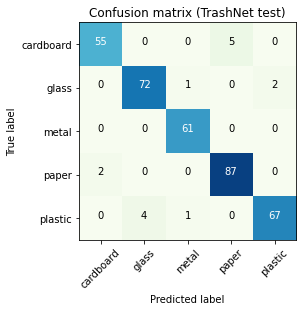

In [26]:

# Test accuracy on original TrashNet testset 
[wrongImage,model]=testAccuracy("xueyingsplitall/testorigin","Confusion matrix (TrashNet test)",label= ["cardboard", "glass","metal", "paper", "plastic"])
# Test accuracy on TrashNet testset + New hand & empty testset
#[wrongImage,model]=testAccuracy("xueyingsplitall/test","Confusion matrix (Mixed test)",label=["cardboard", "empty","glass","hand" ,"metal", "paper", "plastic"])



In [19]:
print(wrongImage)

[(array([[[[253., 237., 221.],
         [253., 237., 221.],
         [253., 237., 221.],
         ...,
         [ 95.,  78.,  52.],
         [ 95.,  78.,  52.],
         [116.,  99.,  73.]],

        [[253., 237., 221.],
         [253., 237., 221.],
         [253., 237., 221.],
         ...,
         [101.,  84.,  58.],
         [104.,  87.,  61.],
         [122., 105.,  79.]],

        [[253., 237., 221.],
         [253., 237., 221.],
         [253., 237., 221.],
         ...,
         [120., 103.,  77.],
         [123., 106.,  80.],
         [121., 104.,  78.]],

        ...,

        [[189., 187., 188.],
         [190., 188., 189.],
         [191., 189., 190.],
         ...,
         [ 34.,  25.,  16.],
         [ 37.,  28.,  19.],
         [ 39.,  30.,  21.]],

        [[189., 187., 188.],
         [190., 188., 189.],
         [191., 189., 190.],
         ...,
         [ 30.,  21.,  12.],
         [ 32.,  23.,  14.],
         [ 32.,  23.,  14.]],

        [[189., 187., 188.],
     

In [27]:
def savemodelh5(model,name="model.h5"):
    model.save(name,include_optimizer=False)
def savemodelpb(model,name="model"):
    model.save(name,include_optimizer=False)
savemodelh5(model,name="best224.h5")